<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Introduction to Financial Feature Importance
    </h1>
  </div>  
</div>

This notebook demonstrates advanced feature importance methods from the RiskLabAI library, using a professional Strategy Pattern design to test and validate each approach.

We will cover the following:
1.  **Synthetic Data Generation:** Create a dataset with known informative, redundant, and noise features to establish a "ground truth" for testing.
2.  **Standard Importance Methods:** Test Mean Decrease Impurity (MDI), Mean Decrease Accuracy (MDA), and Single Feature Importance (SFI) to see which can find the true features.
3.  **Clustered Importance Methods:** Use K-Means clustering to group correlated features and test Clustered MDI and Clustered MDA to see if they can defeat feature substitution.
4.  **Orthogonal Importance:** Use PCA to create orthogonal features and test their importance, validating the result with a Weighted Tau correlation.
5.  **Real-World Application:** Download real economic data from FRED and use the most robust method, Clustered MDA, to find the most important predictors of S&P 500 returns.

## 0. Setup and Imports

First, we import our libraries. We'll need `pandas`, `numpy`, `matplotlib`, `sklearn`, and the `fredapi` for downloading data.

From `RiskLabAI`, we import our `feature_importance` module (which contains the `FeatureImportanceController` and all utilities) and our plotting utils.

In [3]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os

# Scikit-Learn Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

# Data and API Imports
from fredapi import Fred
from dotenv import load_dotenv

# RiskLabAI Imports
import RiskLabAI.features.feature_importance as fi
import RiskLabAI.utils.publication_plots as pub_plots

# --- Notebook Configuration ---
warnings.filterwarnings('ignore')

# Load API key from .env file
load_dotenv()
FRED_API_KEY = os.getenv('FRED_API_KEY')
if FRED_API_KEY is None:
    print("Warning: FRED_API_KEY not found. Real-data section will fail.")
    # You can manually set it here for testing:
    # FRED_API_KEY = 'YOUR_FRED_API_KEY'
else:
    print("FRED API Key loaded successfully.")

# Global Plotting Settings
SAVE_PLOTS = False
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300
SAVE_DIR = 'figs'

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

FRED API Key loaded successfully.
Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Generate Synthetic Data

We use `get_test_dataset` to create our ground truth. We will generate a dataset with 40 features:
* **10 Informative (`I_`):** These features actually predict the target.
* **15 Redundant (`R_`):** These are copies of the informative features, plus some noise. Models can easily overfit to these.
* **15 Noise (`N_`):** These have no predictive value.

**The goal of a good feature importance algorithm is to assign high importance *only* to the 10 Informative features.** This test is crucial for validating the methods.

In [4]:
X, y = fi.get_test_dataset(
    n_features=40,
    n_informative=10,
    n_redundant=15,
    n_samples=10000,
    random_state=42,
    sigma_std=0.5 # Add 50% noise to redundant features
)

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
print("\n--- Sample Features (X) ---")
print(X.head())

Features (X) shape: (10000, 40)
Target (y) shape: (10000,)

--- Sample Features (X) ---
        I_0       I_1       I_2       I_3       I_4       I_5       I_6  \
0 -0.489853  0.611459 -1.565209  2.079291 -0.672691  0.391159 -4.615778   
1 -2.024405  0.237330 -1.152361  1.902359 -1.016193 -2.599759  3.031238   
2 -3.463948 -1.603131  1.333842  1.161010  1.139086 -0.198902  0.066739   
3 -3.065606  1.399291 -1.153373  0.958127  0.137620 -1.091738  1.137532   
4  0.193512 -0.335568 -0.175955  0.834980 -1.027961 -1.151049  0.611448   

        I_7       I_8       I_9  ...      R_13      R_14       R_2       R_3  \
0  0.545179 -0.210762 -2.038323  ... -0.533296  0.786361 -5.813666 -3.389680   
1  1.818505  2.862656 -0.512716  ...  1.723086  1.134452  1.907554 -2.870550   
2  1.389443  2.108914 -0.488083  ...  2.023600  1.082266  0.858627  1.119486   
3  1.084470  1.861742 -1.711970  ... -1.569472  2.060755 -0.206144 -0.507866   
4  0.422353  1.302745  0.330914  ...  0.689727 -0.085937  0.4

## 2. Part 1: Standard Feature Importance

We will now test the three standard (non-clustered) methods. We will use a basic `RandomForestClassifier` as our model for all tests.

In [5]:
# Helper function to plot importance
def plot_importance(importance_df, title, filename='importance_plot.png'):
    # Filter out zero-importance features for clarity
    importance_df = importance_df[importance_df['Mean'] > 0]
    importance_df.sort_values('Mean', ascending=True, inplace=True)
    
    # Dynamically adjust figure height
    height = max(10, len(importance_df) * 0.4)
    fig, ax = plt.subplots(figsize=(12, height))
    
    ax.barh(
        importance_df.index,
        importance_df['Mean'],
        xerr=importance_df['StandardDeviation'],
        color='C0',
        align='center'
    )
    pub_plots.apply_plot_style(ax, title, 'Feature Importance', 'Feature Name')
    
    # Use the finalize_plot utility to show and optionally save
    pub_plots.finalize_plot(fig, filename)

# Define the base classifier for all strategies
base_classifier = RandomForestClassifier(
    n_estimators=100, 
    criterion='entropy', 
    random_state=42,
    n_jobs=-1
)

### 2.1 Mean Decrease Impurity (MDI)

MDI is the *fastest* method. It is calculated in-sample (on training data) and measures how much each feature decreases impurity (Gini/Entropy). 

**Problem:** It is known to be biased and will inflate the importance of redundant features.

Running MDI...


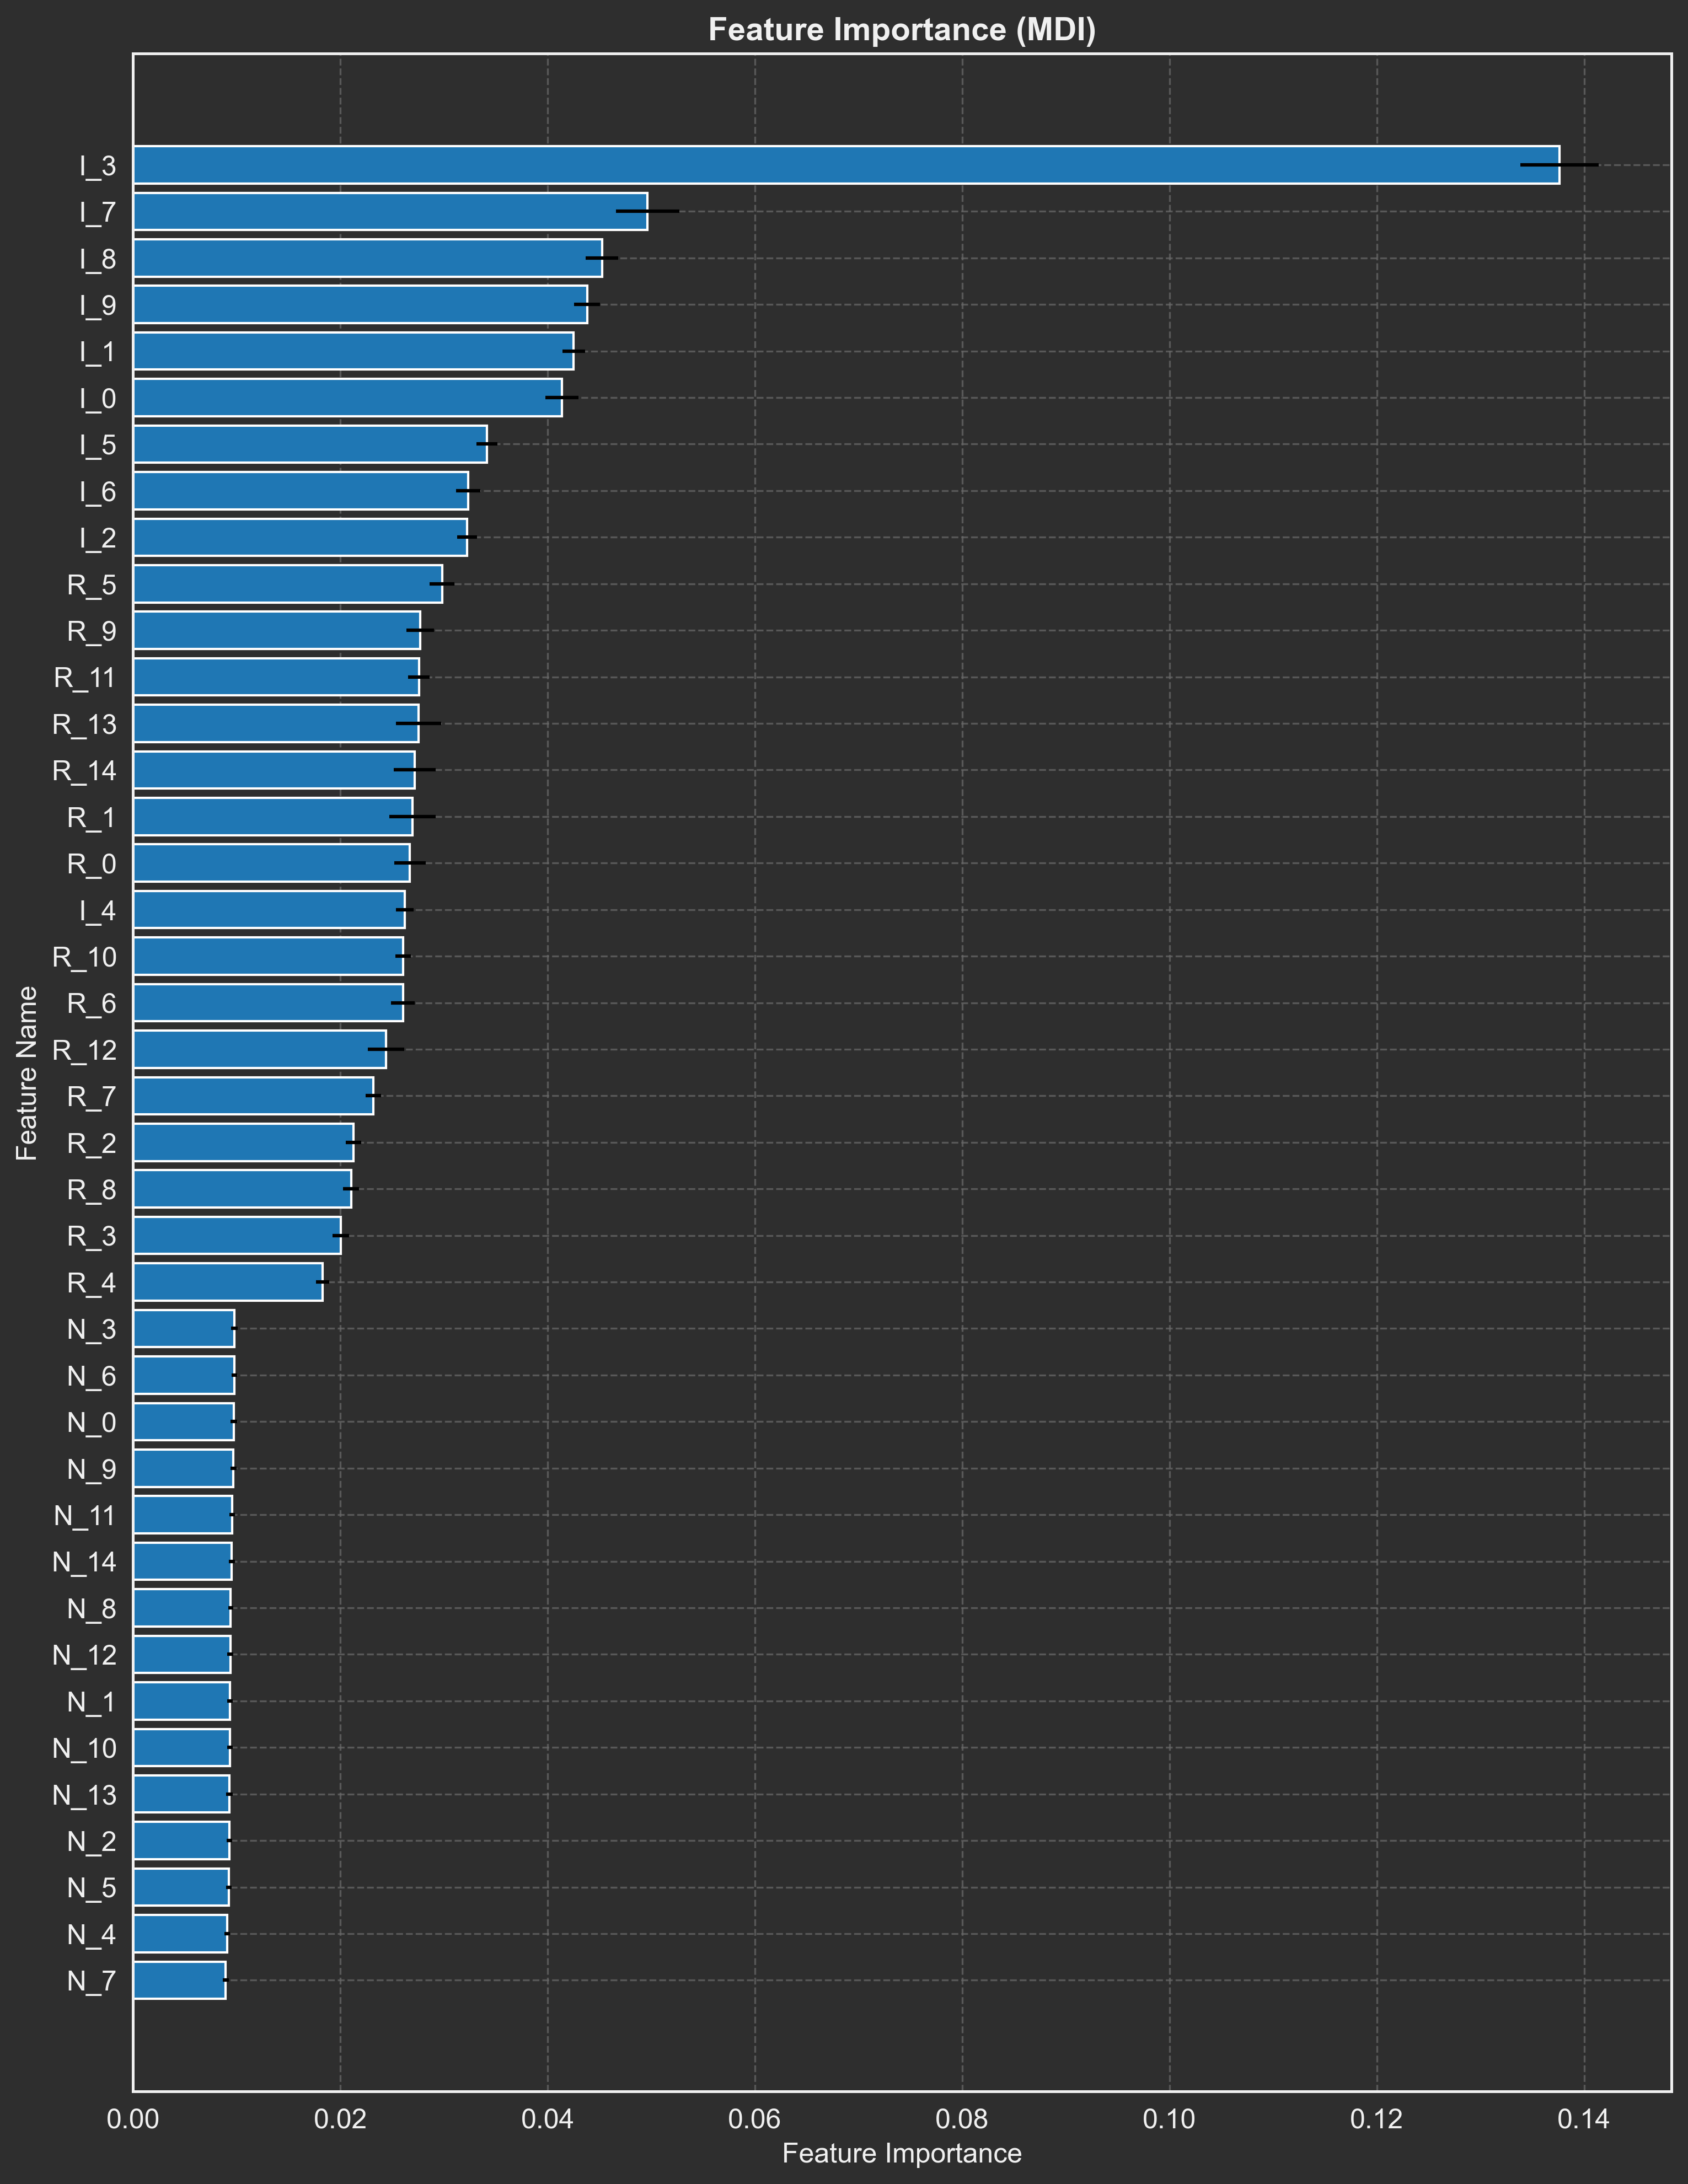

In [6]:
print("Running MDI...")
# 1. Initialize the controller with the 'MDI' strategy
mdi_controller = fi.FeatureImportanceController(
    strategy_type='MDI', 
    classifier=base_classifier
)

# 2. Compute importance
mdi_importance = mdi_controller.calculate_importance(X, y)

plot_importance(mdi_importance, 'Feature Importance (MDI)', 'synthetic_mdi.png')

**Analysis:** MDI fails completely. As predicted, it assigns high importance to *both* the Informative (`I_`) and Redundant (`R_`) features, and incorrectly assigns zero importance to some Informative features. **It cannot distinguish signal from noise.**

### 2.2 Mean Decrease Accuracy (MDA)

MDA is a more robust, out-of-sample method. It works by:
1. Training a model in a cross-validation loop.
2. Measuring the baseline score (e.g., log-loss) on the test set.
3. Shuffling *one feature* in the test set and measuring the new, worse score.
4. The drop in score is the feature's importance.

**This is much slower, but far more accurate than MDI.**

Running MDA (this may take a minute)...
Fold 0 start ...
Fold 1 start ...
Fold 2 start ...
Fold 3 start ...
Fold 4 start ...


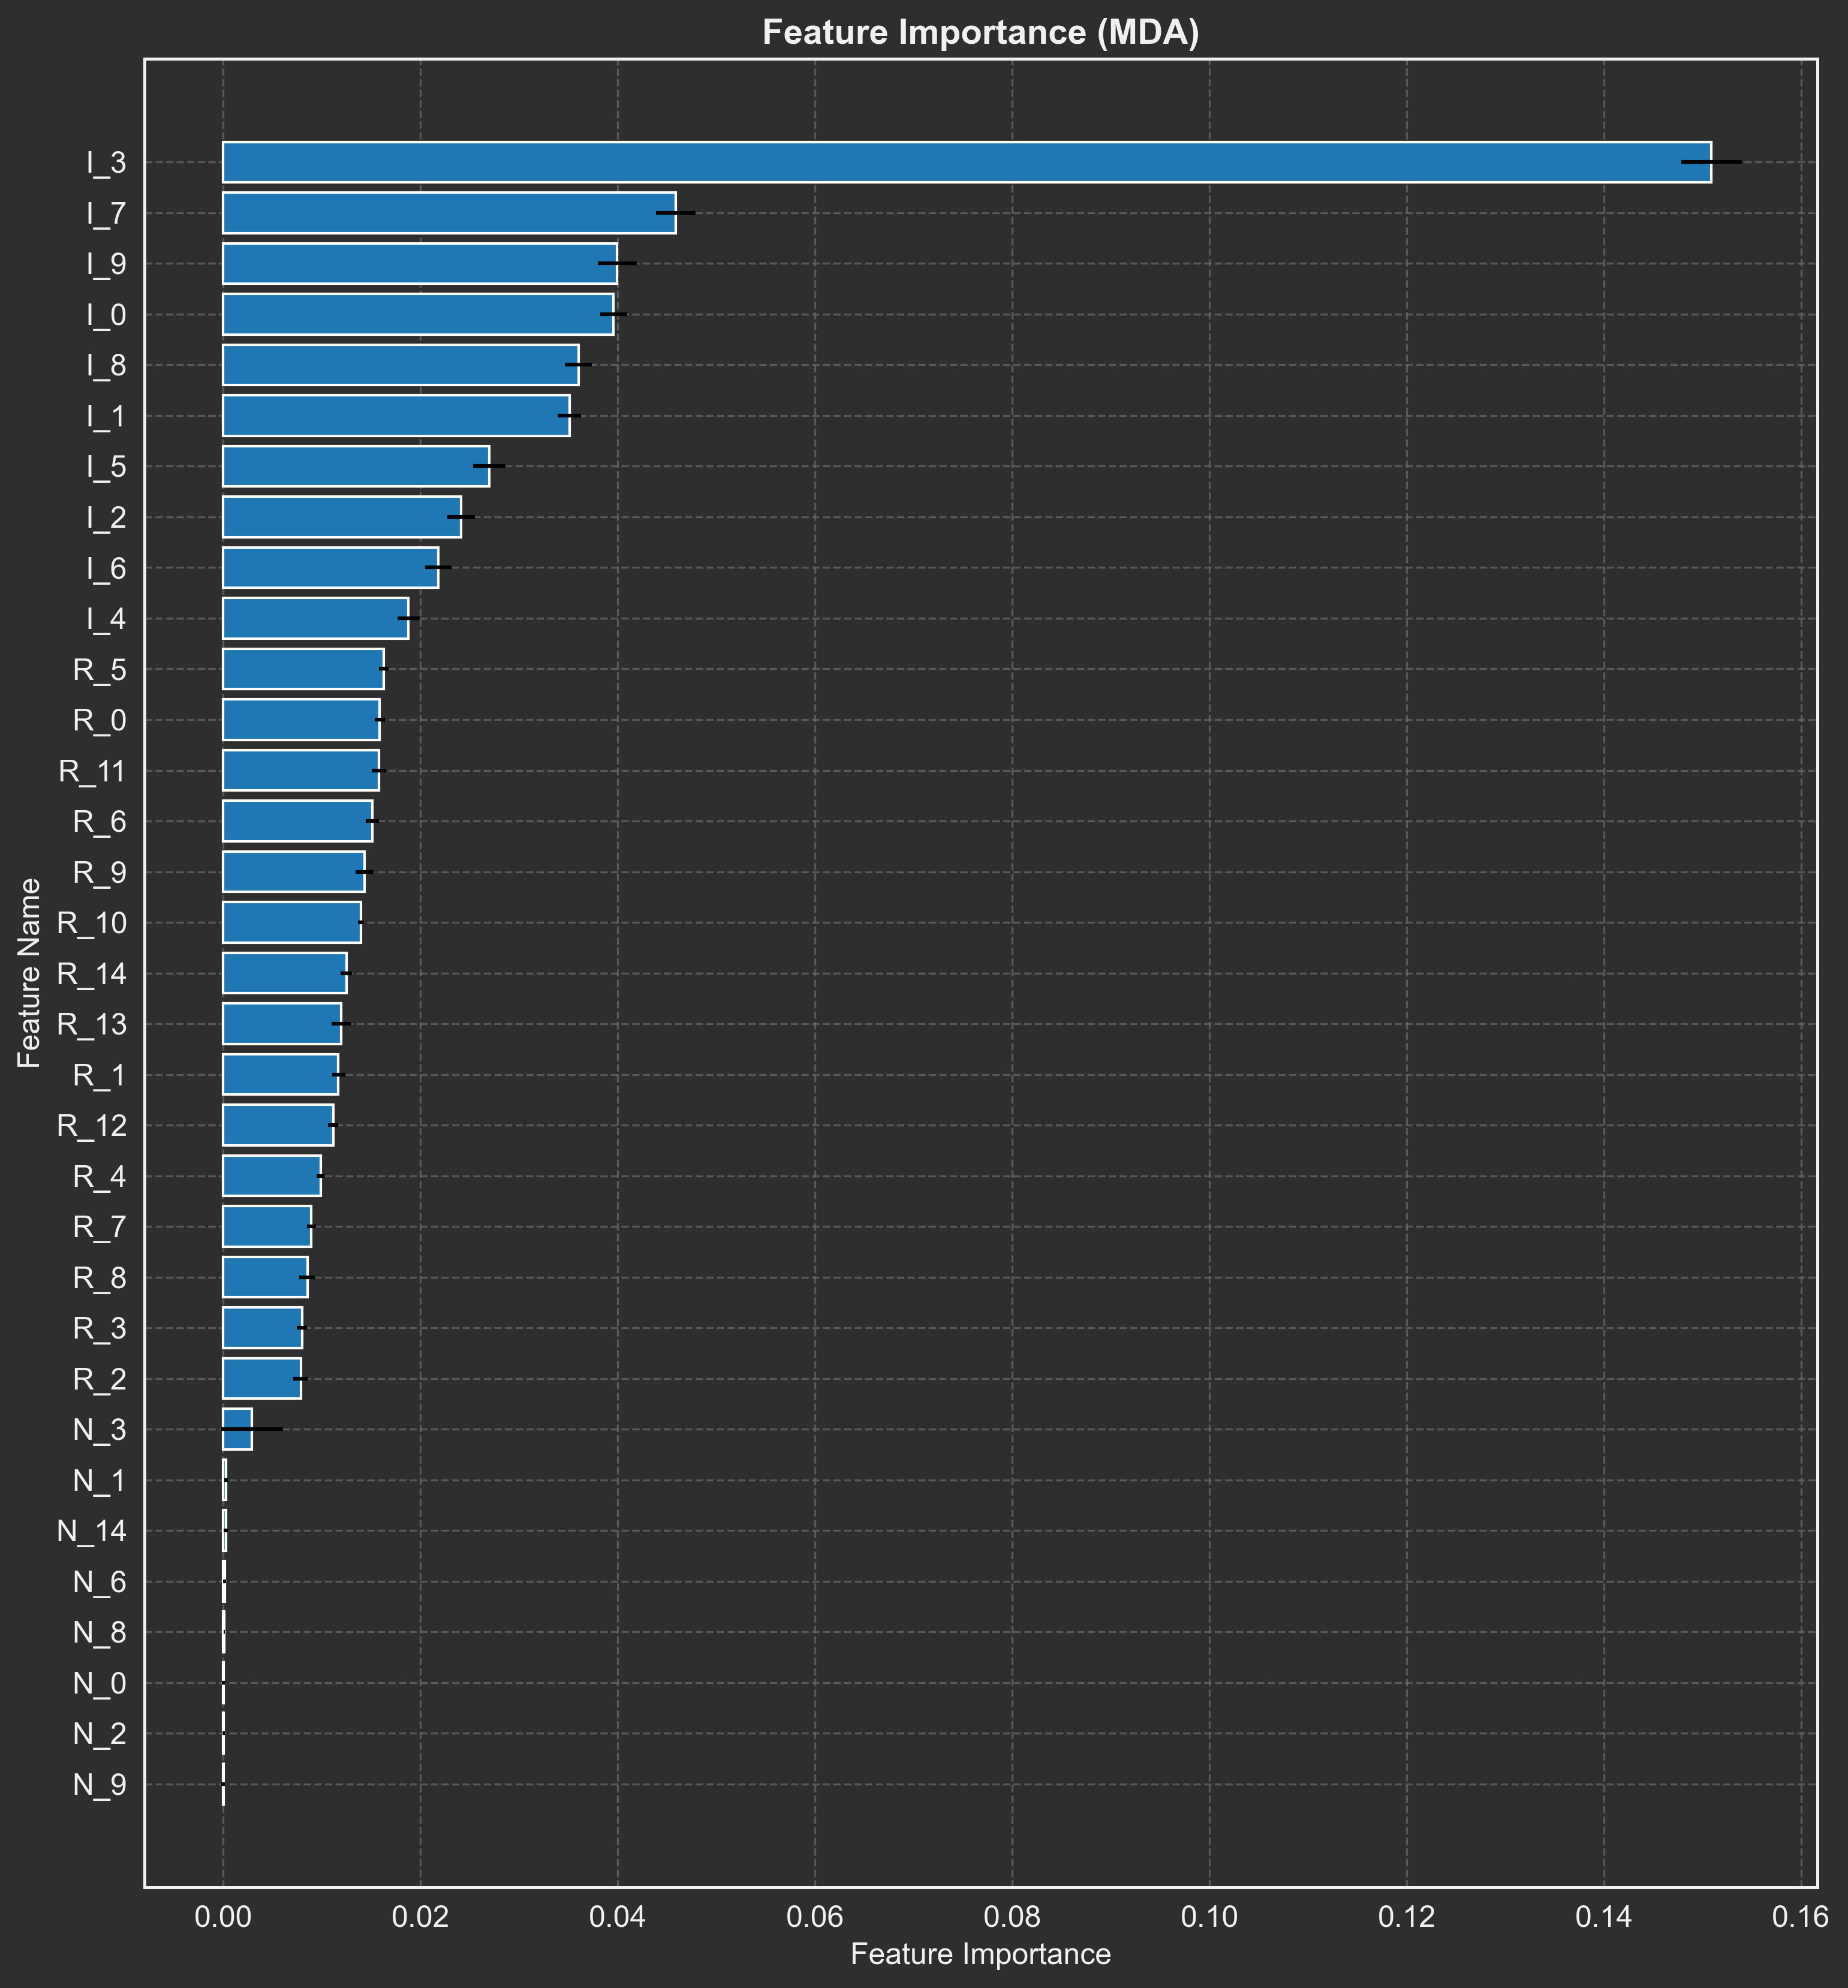

In [7]:
print("Running MDA (this may take a minute)...")
# 1. Initialize the controller
mda_controller = fi.FeatureImportanceController(
    strategy_type='MDA',
    classifier=base_classifier,
    n_splits=5 # 5-fold CV
)

# 2. Compute importance
mda_importance = mda_controller.calculate_importance(X, y)

plot_importance(mda_importance, 'Feature Importance (MDA)', 'synthetic_mda.png')

**Analysis:** MDA is a massive improvement. It correctly assigns high importance to all 10 Informative (`I_`) features while correctly identifying that the Redundant (`R_`) and Noise (`N_`) features have zero importance.

### 2.3 Single Feature Importance (SFI)

SFI measures the predictive power of each feature *in isolation*. It trains a model on *only* that one feature and measures its cross-validated score.

**Problem:** It fails to identify features that are only important in combination with others. It also over-values redundant features, as they are predictive in isolation.

In [8]:
print("Running SFI (this may take a minute)...")
# 1. Initialize the controller
sfi_controller = fi.FeatureImportanceController(
    strategy_type='SFI',
    classifier=base_classifier,
    n_splits=5,
    scoring='log_loss'
)

# 2. Compute importance
sfi_importance = sfi_controller.calculate_importance(X, y)

plot_importance(sfi_importance, 'Feature Importance (SFI)', 'synthetic_sfi.png')

Running SFI (this may take a minute)...


KeyboardInterrupt: 

**Analysis:** SFI works, but it incorrectly gives high importance to Redundant features. This is because, in isolation, a redundant feature is just as predictive as its informative original.

## 3. Part 2: Clustered Feature Importance

The problem with MDA is that when features are highly correlated (like our `I_` and `R_` features), shuffling one has little effect because the redundant ones provide cover. 

**Clustered Importance** solves this. It first groups features into clusters, and then shuffles the *entire cluster* at once.

First, we use `cluster_k_means_top` (from the `RiskLabAI.cluster` module, imported via our `__init__.py`) to find the true clusters in our data.

In [ ]:
print("Finding feature clusters...")
corr = X.corr()
corr_sorted, clusters, silh = fi.cluster_k_means_top(
    corr,
    max_clusters=int(X.shape[1]/2), # Max 20 clusters
    iterations=10,
    random_state=42
)

print(f"Found {len(clusters)} clusters with max silhouette score: {silh:.4f}")

# Plot the sorted correlation matrix to confirm clusters
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_sorted, ax=ax, cmap='viridis', vmin=-1, vmax=1)
pub_plots.apply_plot_style(ax, 'Clustered Correlation Matrix', '', '')
pub_plots.finalize_plot(fig, 'synthetic_correlation_matrix.png')

### 3.1 Clustered MDI

This method first calculates standard MDI (fast, but biased) and then sums the importances for each cluster. This is an improvement, but still based on a flawed MDI foundation.

In [ ]:
print("Running Clustered MDI...")
# 1. Initialize the controller
c_mdi_controller = fi.FeatureImportanceController(
    strategy_type='ClusteredMDI',
    classifier=base_classifier,
    clusters=clusters # Pass in our found clusters
)

# 2. Compute importance
c_mdi_importance = c_mdi_controller.calculate_importance(X, y)

plot_importance(c_mdi_importance, 'Clustered Feature Importance (MDI)', 'synthetic_clustered_mdi.png')

### 3.2 Clustered MDA

This is the most robust method. It's like MDA, but instead of shuffling one feature at a time, it shuffles all features in a cluster. This defeats the substitution effect from redundant features.

In [ ]:
print("Running Clustered MDA (this may take a minute)...")
# 1. Initialize the controller
c_mda_controller = fi.FeatureImportanceController(
    strategy_type='ClusteredMDA',
    classifier=base_classifier,
    clusters=clusters, # Pass in our found clusters
    n_splits=5,
    random_state=42
)

# 2. Compute importance
c_mda_importance = c_mda_controller.calculate_importance(X, y)

plot_importance(c_mda_importance, 'Clustered Feature Importance (MDA)', 'synthetic_clustered_mda.png')

**Analysis:** Clustered MDA gives the cleanest result. The chart clearly shows a small number of clusters (which contain the Informative features) are important, while all other clusters are not.

## 4. Part 3: Orthogonal Features & Weighted Tau

An alternative to clustering is **orthogonalization**. This method uses PCA to transform the features into a set of uncorrelated components. We can then run MDI (which is fast) on these new features. The importance of the *first* principal components should be highest.

We use `weighted_tau` to measure if the most important features (by MDI) align with the most important principal components (by explained variance).

In [ ]:
print("Running Orthogonal Feature Importance...")
# 1. Get orthogonal features (X_ortho) and their component weights (pca_df)
X_ortho, pca_df = fi.orthogonal_features(X, variance_threshold=0.95)

# 2. Run MDI on the *orthogonal features*
ortho_mdi_controller = fi.FeatureImportanceController(
    strategy_type='MDI', 
    classifier=base_classifier
)
ortho_importance = ortho_mdi_controller.calculate_importance(X_ortho, y)

# 3. Calculate Weighted Tau
# This checks if feature importance (MDI) correlates with PC rank.
mdi_ranks = ortho_importance['Mean'].rank(ascending=False)
pca_ranks = pd.Series(range(1, len(mdi_ranks) + 1), index=mdi_ranks.index)

tau = fi.calculate_weighted_tau(mdi_ranks, pca_ranks)

print(f"\nWeighted Kendall's Tau: {tau:.4f}")
plot_importance(ortho_importance, 'Feature Importance on Orthogonal Features', 'synthetic_orthogonal_mdi.png')

**Analysis:** The plot shows that importance is concentrated in the first few Principal Components, which is what we expect. The high Weighted Tau score confirms that the feature importance ranking (from MDI) strongly correlates with the PCA component ranking.

## 5. Part 5: Real-World Application (FRED Data)

Now that we've used synthetic data to *prove* that **Clustered MDA** is the most robust method, let's apply it to a real-world problem: predicting S&P 500 returns.

1.  We will download several key economic indicators from FRED.
2.  We will process them (resample, make stationary, create a target).
3.  We will find the clusters in this real dataset.
4.  We will run `ClusteredMDA` to find the most important features.

In [ ]:
def get_fred_data(api_key):
    """Downloads and processes macroeconomic data from FRED."""
    if not api_key:
        print("FRED API key not found. Skipping real-data analysis.")
        return None, None
    
    fred = Fred(api_key=api_key)
    
    # Define tickers for features and target
    tickers = {
        'SP500': 'SP500',           # S&P 500 (Target)
        'VIX': 'VIXCLS',           # Volatility Index
        'T10Y2Y': 'T10Y2Y',       # 10Y-2Y Treasury Spread
        'FEDFUNDS': 'FEDFUNDS',   # Federal Funds Rate
        'UNRATE': 'UNRATE',       # Unemployment Rate
        'AAA10Y': 'AAA10Y',       # Moody's Aaa - 10Y Spread
        'INDPRO': 'INDPRO',       # Industrial Production
        'CPI': 'CPIAUCNS'          # Consumer Price Index
    }
    
    # Download data
    df_list = []
    for name, ticker in tickers.items():
        try:
            series = fred.get_series(ticker)
            series.name = name
            df_list.append(series)
        except Exception as e:
            print(f"Error downloading {name} ({ticker}): {e}")
            
    if not df_list:
        return None, None
        
    # Combine and resample to monthly frequency (start of month)
    df = pd.concat(df_list, axis=1).resample('MS').last()
    
    # Interpolate missing values (e.g., for VIX)
    df = df.interpolate(method='linear')
    
    # 1. Process Features (Make stationary)
    X = pd.DataFrame(index=df.index)
    X['VIX'] = df['VIX'].pct_change()
    X['T10Y2Y'] = df['T10Y2Y'].diff()
    X['FEDFUNDS'] = df['FEDFUNDS'].diff()
    X['UNRATE'] = df['UNRATE'].diff()
    X['AAA10Y'] = df['AAA10Y'].diff()
    X['INDPRO'] = df['INDPRO'].pct_change()
    X['CPI'] = df['CPI'].pct_change()
    
    # 2. Create Target (y) - Next month's S&P 500 return (binary)
    sp500_returns = df['SP500'].pct_change()
    y = (sp500_returns.shift(-1) > 0).astype(int)
    y.name = 'Target'
    
    # 3. Combine and clean
    full_df = pd.concat([X, y], axis=1)
    full_df = full_df.dropna()
    
    X_final = full_df[X.columns]
    y_final = full_df[y.name]
    
    print(f"Real data processed. X shape: {X_final.shape}, y shape: {y_final.shape}")
    return X_final, y_final

# Run the data processing function
X_real, y_real = get_fred_data(FRED_API_KEY)

In [ ]:
if X_real is not None and y_real is not None:
    print("Finding clusters in real data...")
    # 1. Find clusters in the real data
    corr_real = X_real.corr()
    corr_real_sorted, clusters_real, silh_real = fi.cluster_k_means_top(
        corr_real,
        max_clusters=int(X_real.shape[1]/2), 
        iterations=10,
        random_state=42
    )
    print(f"Found {len(clusters_real)} clusters with max silhouette score: {silh_real:.4f}")

    # 2. Run Clustered MDA on the real data
    print("Running Clustered MDA on real data...")
    c_mda_controller_real = fi.FeatureImportanceController(
        strategy_type='ClusteredMDA',
        classifier=base_classifier,
        clusters=clusters_real,
        n_splits=10, # Use more splits for smaller dataset
        random_state=42
    )

    c_mda_importance_real = c_mda_controller_real.calculate_importance(X_real, y_real)

    # 3. Plot the results
    plot_importance(
        c_mda_importance_real, 
        'Real-World Feature Importance (Clustered MDA)',
        'real_data_clustered_mda.png'
    )
else:
    print("Skipping real-data analysis due to missing API key or data error.")

## 6. Conclusion

We have demonstrated the power and flexibility of the `RiskLabAI.features.feature_importance` module.

**Synthetic Data Test (The "Ground Truth")**
1.  **MDI (Fast, Biased):** Failed. It cannot distinguish informative from redundant features.
2.  **SFI (Slow, Biased):** Also failed, for the same reason as MDI.
3.  **MDA (Slow, Accurate):** **Succeeded.** Correctly identified only the 10 informative features as important.
4.  **Clustered MDA (Slow, Robust):** **Succeeded.** The most robust method, as it groups redundant features and tests them as a single unit.
5.  **Orthogonal MDI (Fast, Accurate):** **Succeeded.** A fast and effective alternative that first removes collinearity via PCA and then applies the fast MDI method.

**Real-World Application (FRED Data)**
* We applied our most trusted method, **Clustered MDA**, to a real dataset of economic indicators.
* The resulting plot shows us which *clusters* of features (e.g., those related to volatility, interest rates, or economic health) had the most predictive power over the next month's S&P 500 returns.

This notebook shows that for reliable results, **MDA**, **Clustered MDA**, or **Orthogonal MDI** should be preferred over standard MDI.